In [46]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt


# Loading and understanding the data

In [47]:
train_path = './house_price_data/train.csv'
test_path = './house_price_data/test.csv' 

In [48]:
data_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

81 features -> 79 features column (except `target` and `id`)

In [49]:
print(data_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


In [50]:
data_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [51]:
data_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice'>

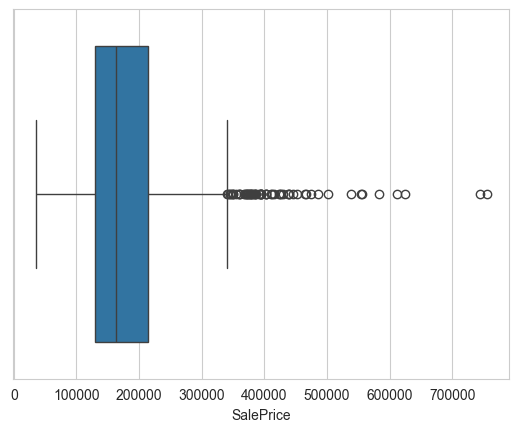

In [52]:
sns.boxplot(x = data_df['SalePrice'])

<Axes: xlabel='SalePrice', ylabel='Density'>

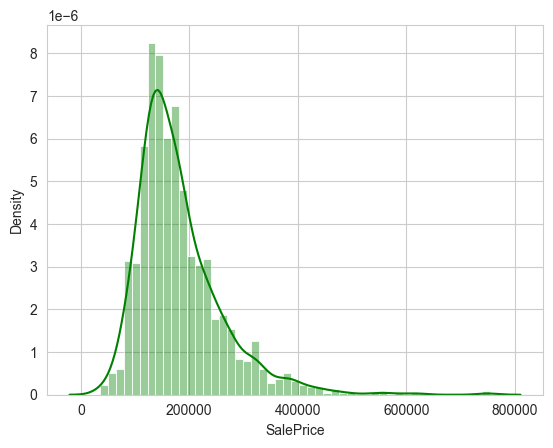

In [53]:
sns.histplot(data_df['SalePrice'], kde=True, stat='density', color='g', alpha=0.4, kde_kws=dict(cut=3))

Right-skewed distribution with the pick around 160k and long tail with maximum around 800k

In [54]:
data_df['SalePrice'].skew()

np.float64(1.8828757597682129)

Text(171.72222222222234, 0.5, 'Features')

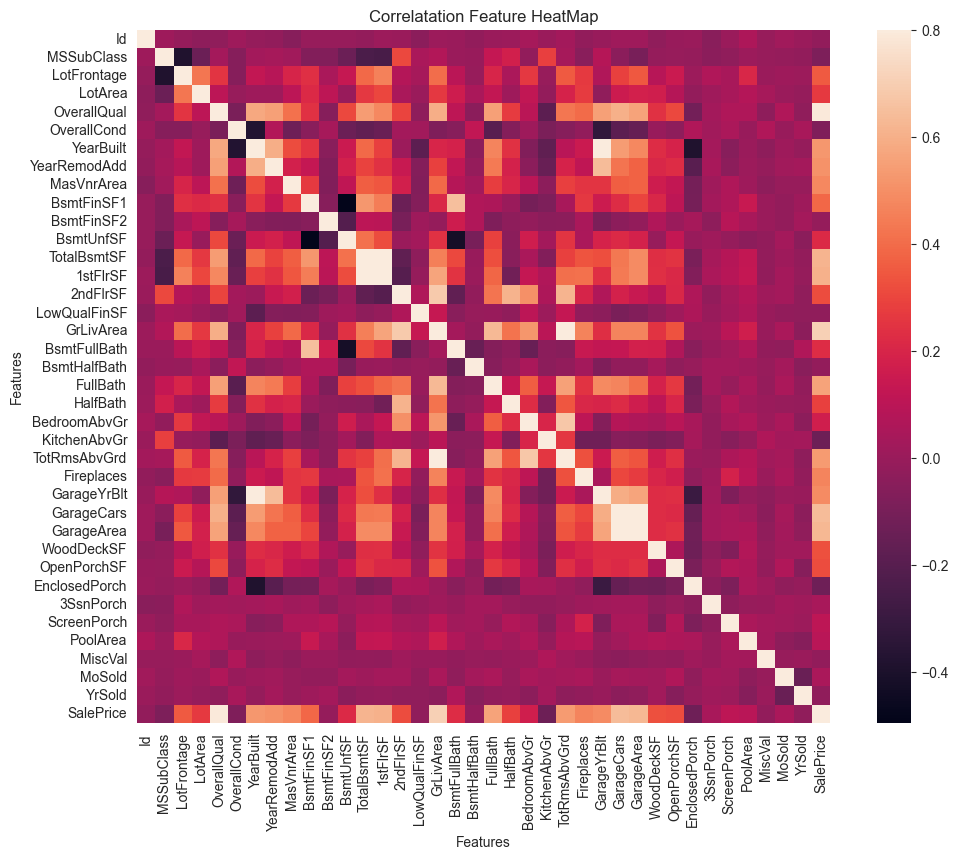

In [55]:
#correlation matrix
corr_mat = data_df.corr(numeric_only=True)
plt.figure(figsize=(12, 9))

sns.heatmap(corr_mat, vmax=.8,square=True)

plt.title("Correlatation Feature HeatMap")
plt.xlabel("Features")
plt.ylabel("Features")

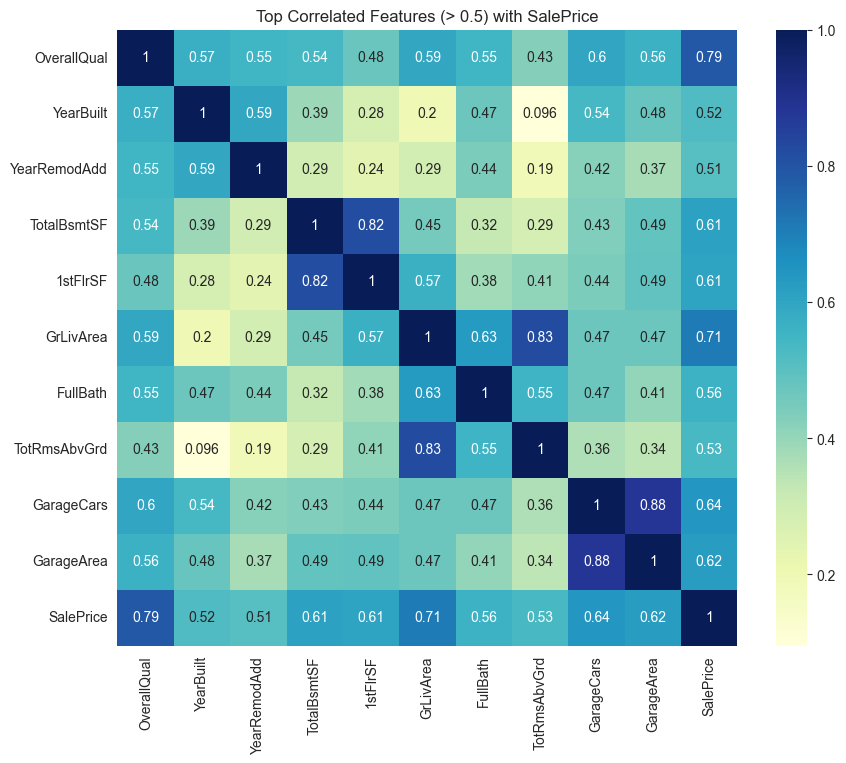

In [56]:
corr_mat = data_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))

top_corr = corr_mat.index[abs(corr_mat['SalePrice'])>0.5]
sns.heatmap(data_df[top_corr].corr(), annot=True, cmap='YlGnBu')
plt.title("Top Correlated Features (> 0.5) with SalePrice")
plt.show()

- OverallQual and GrLivArea seem to be the most correlated to SalePrice

In [57]:
corr = data_df.corr(numeric_only=True).drop('SalePrice')
corr.sort_values(['SalePrice'], ascending=False, inplace=True)
print(corr.SalePrice)

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


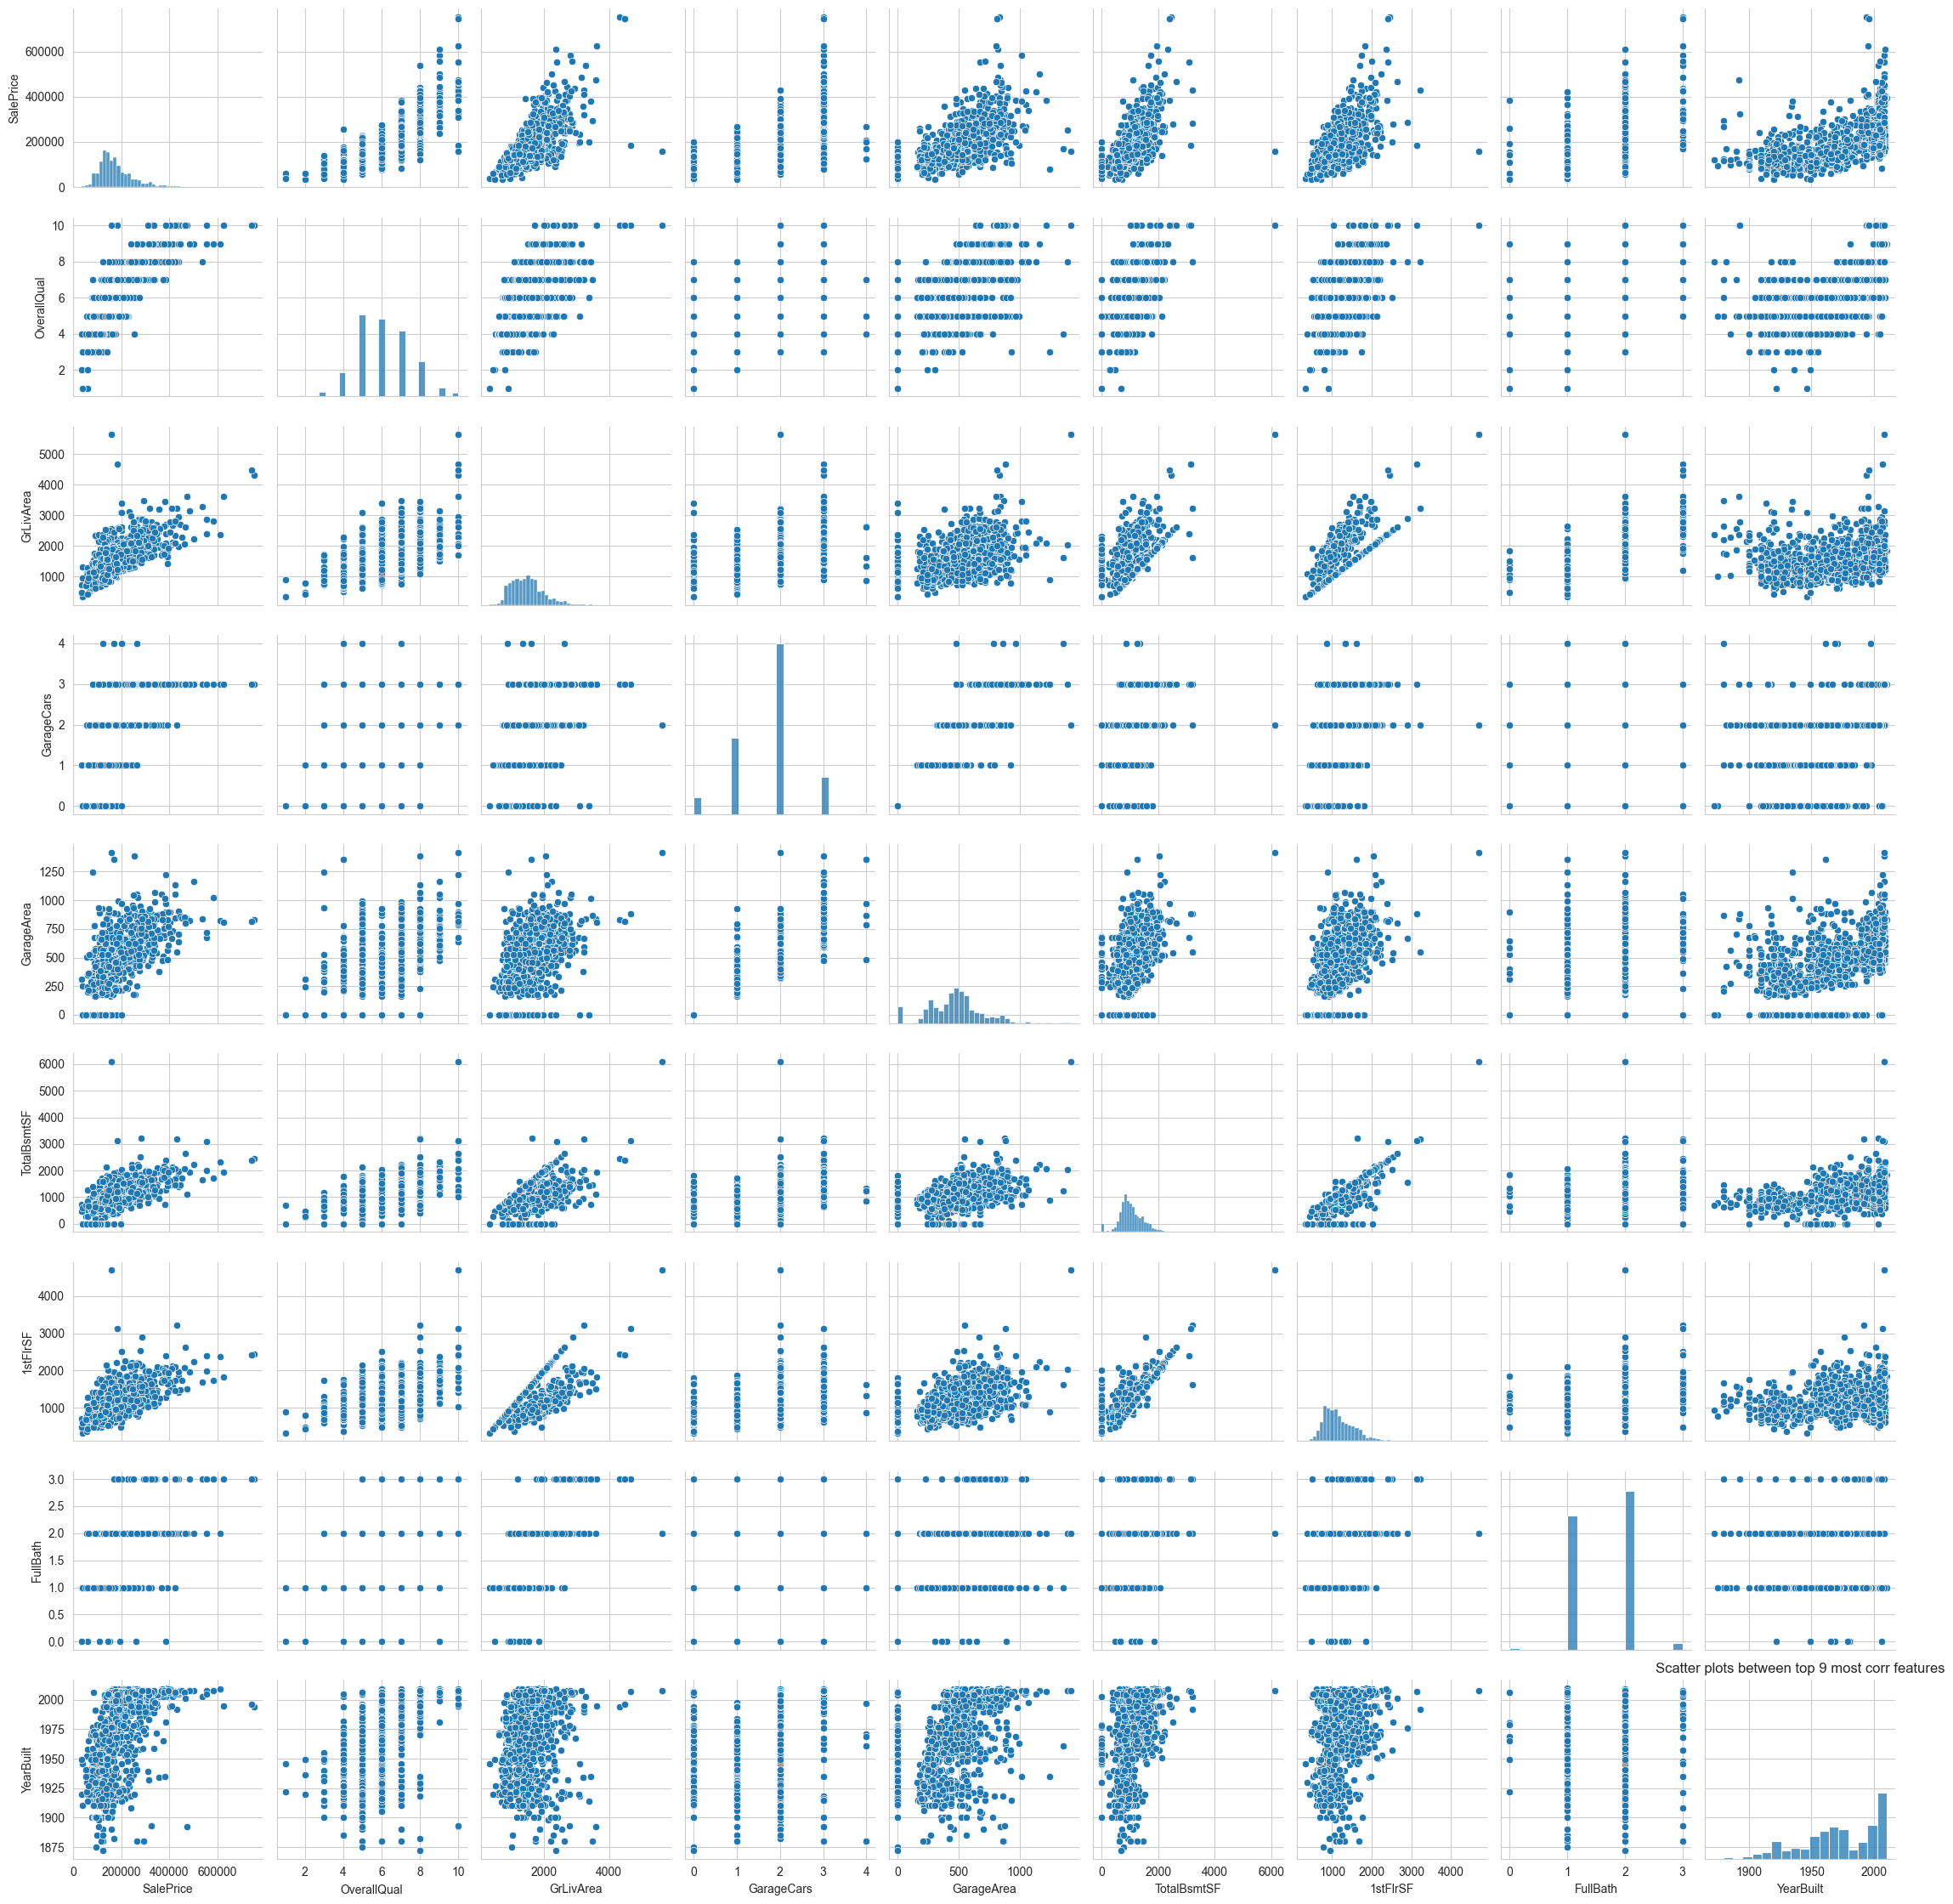

In [58]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars','GarageArea', 'TotalBsmtSF','1stFlrSF','FullBath','YearBuilt']
sns_plot = sns.pairplot(data_df[cols])

plt.title('Scatter plots between top 9 most corr features')
plt.tight_layout()
plt.show()

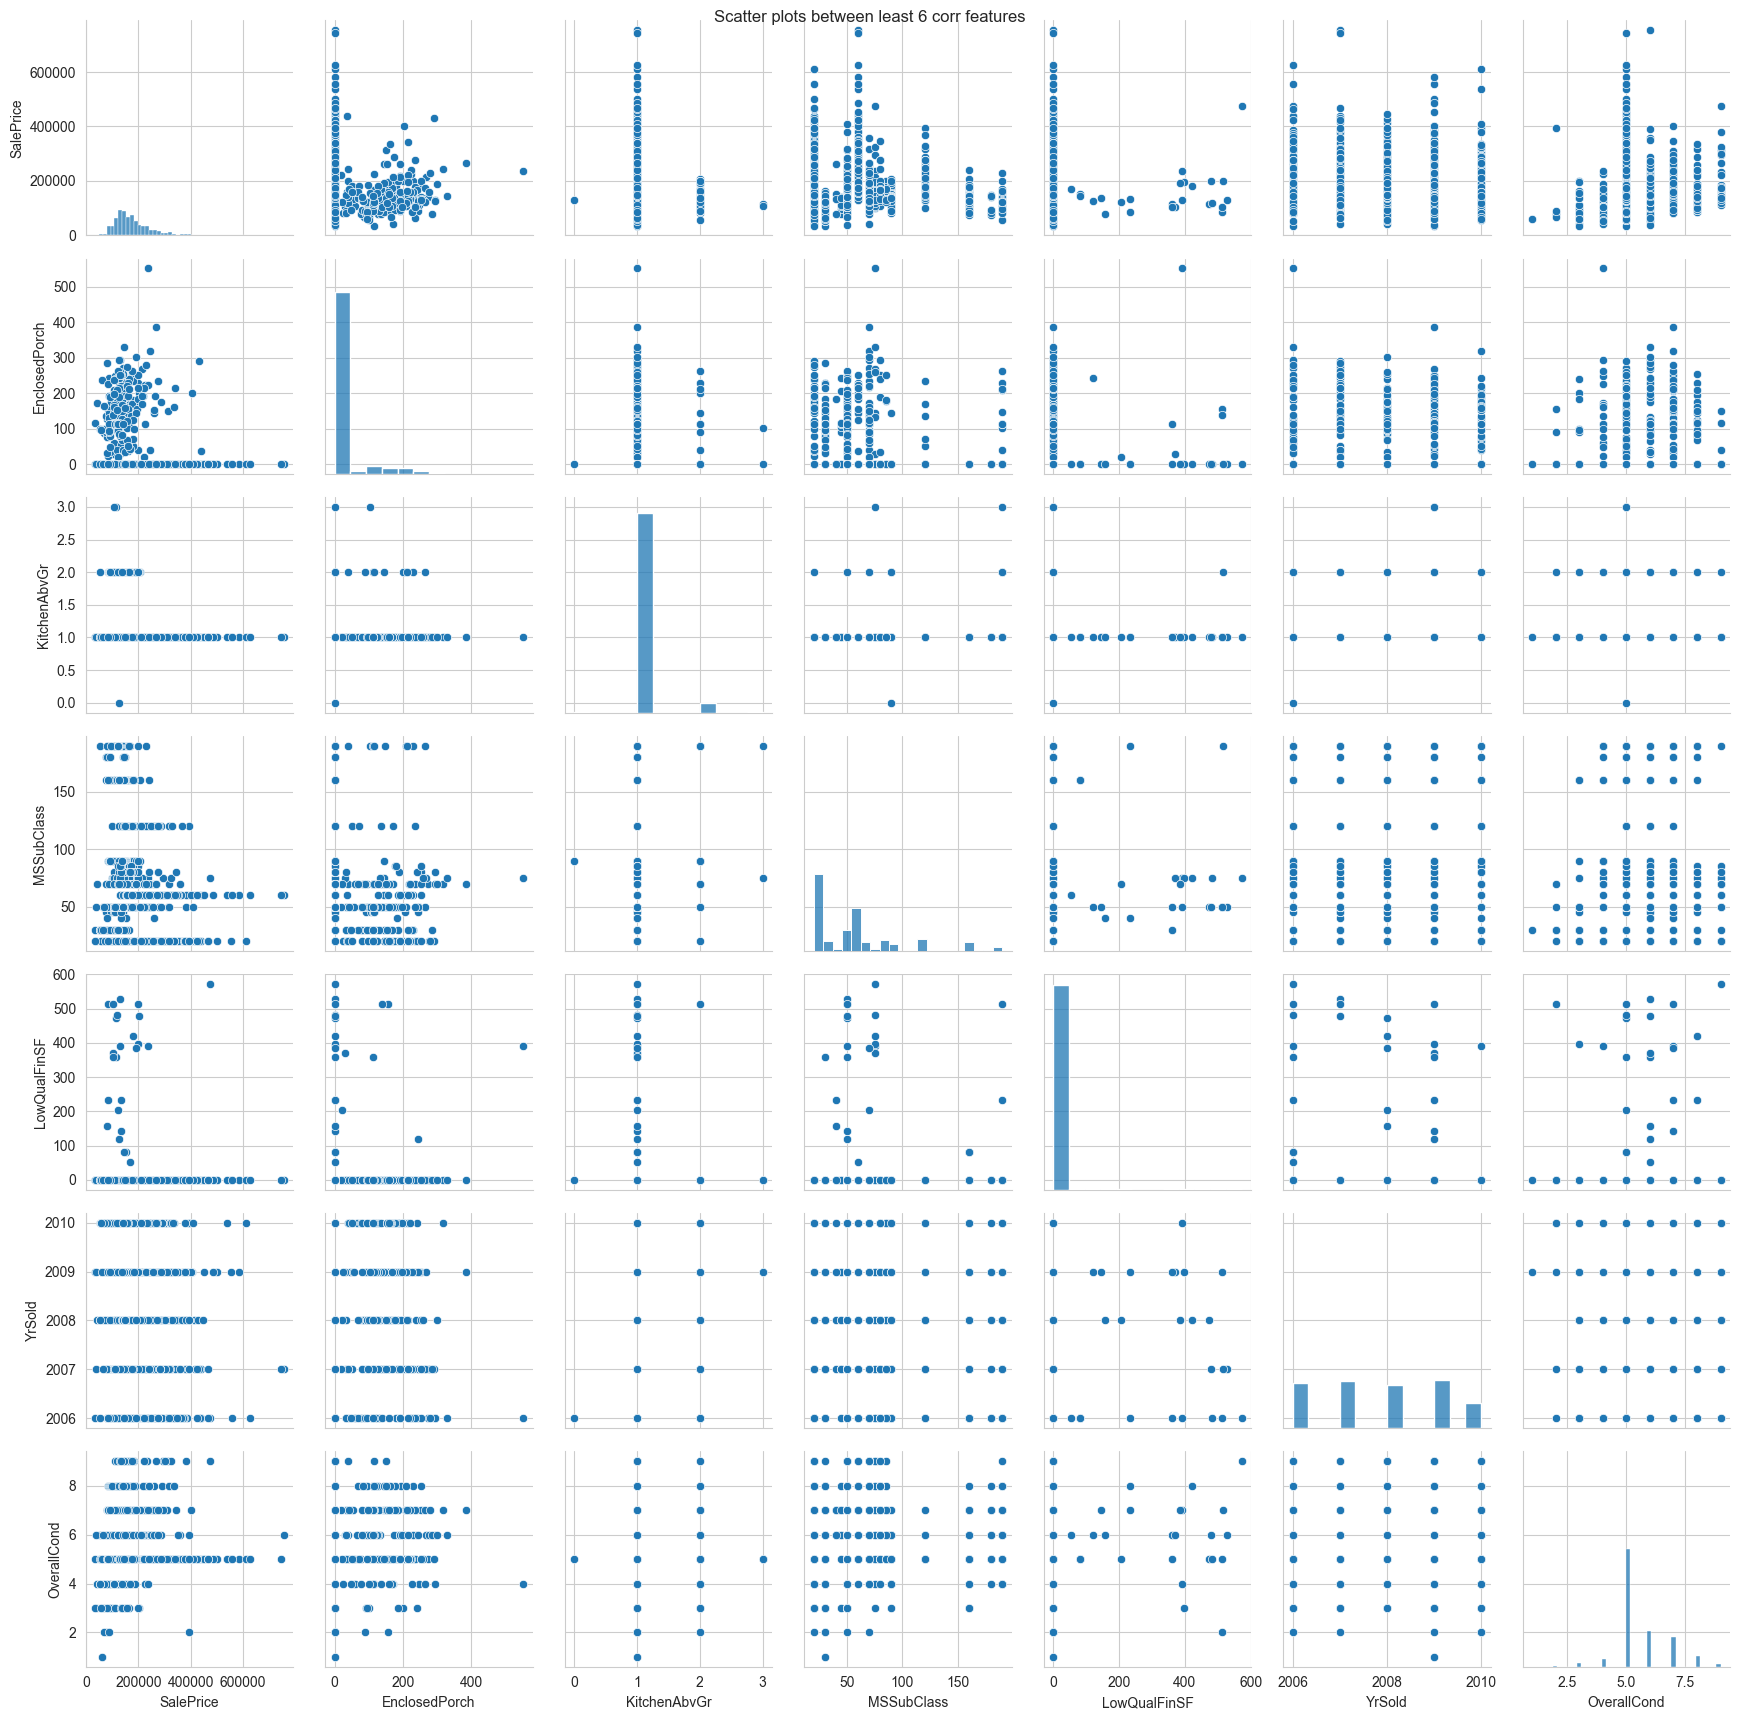

In [59]:
cols = ['SalePrice','EnclosedPorch', 'KitchenAbvGr', 'MSSubClass', 'LowQualFinSF','YrSold', 'OverallCond']
sns_plot = sns.pairplot(data_df[cols])

plt.suptitle('Scatter plots between least 6 corr features')
plt.tight_layout()
plt.show()

# Handing Data

In [60]:
train_id = data_df['Id']
test_id = test_df['Id']

data_df.drop(['Id'], axis=1, inplace=True)
test_df.drop(['Id'], axis=1, inplace=True)

data_df.shape, test_df.shape

((1460, 80), (1459, 79))

## Handling outliers


In [61]:
edgecolor = 'black'
sns.set_style('whitegrid') 

def scatter_plot_with_sale_price(column_name):
    plt.scatter(data_df[column_name], data_df['SalePrice'], edgecolor=edgecolor)
    plt.xlabel(column_name)
    plt.ylabel('SalePrice')
    plt.title(f'Scatter plot of {column_name} vs SalePrice')
    plt.show()

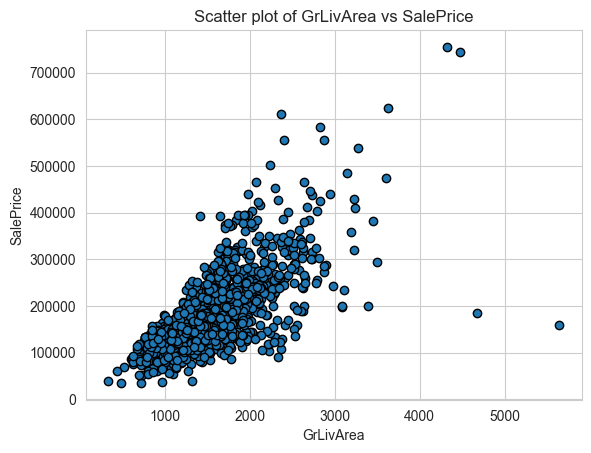

In [62]:
scatter_plot_with_sale_price('GrLivArea')

- Some outliers can negatively affect the prediction highly -> should delete them

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

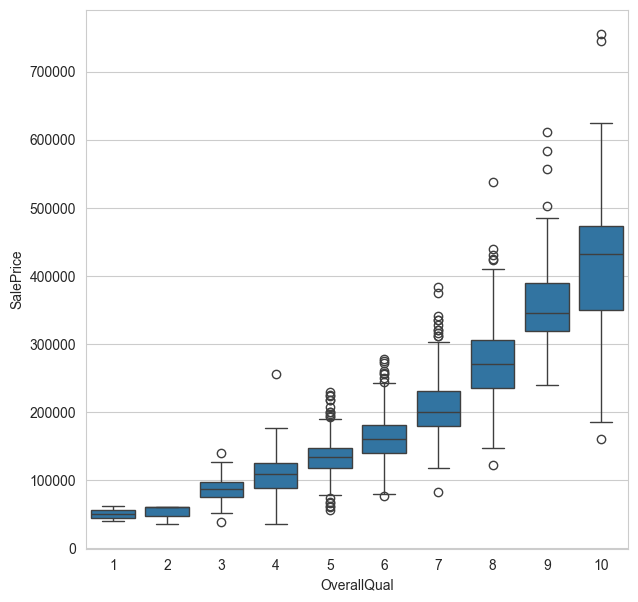

In [63]:
# plot a box for categorical features: OverallQual

plt.figure(figsize=(7, 7))
data = pd.concat([data_df['SalePrice'], data_df['OverallQual']], axis=1)
sns.boxplot(x=data_df['OverallQual'], y='SalePrice', data=data)

Skewness: 1.882876
Kurtosis: 6.536282


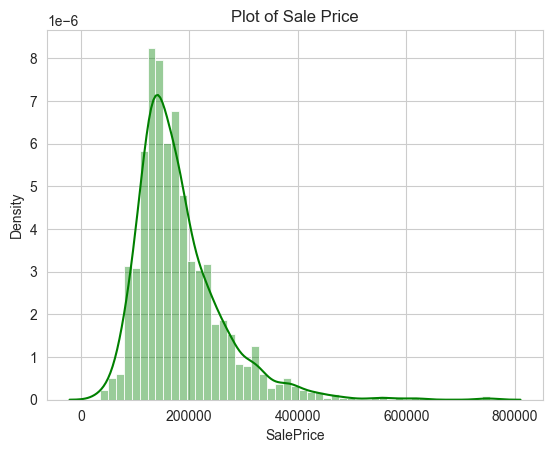

In [64]:
sns.histplot(data_df['SalePrice'], kde=True, stat='density', color='g', alpha=0.4, kde_kws=dict(cut=3))
plt.title( "Plot of Sale Price")

print("Skewness: %f" % data_df['SalePrice'].skew())
print("Kurtosis: %f" % data_df['SalePrice'].kurt())

Using Logarithm transformation to reduce skew

Text(0.5, 1.0, 'Plot of Sale Price after log transformation')

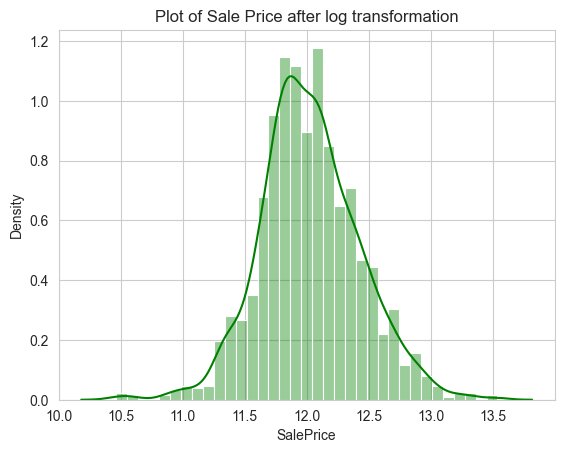

In [65]:
data_df['SalePrice'] = np.log(data_df['SalePrice'])
# new distribution
sns.histplot(data_df['SalePrice'], kde=True, stat='density', color='g', alpha=0.4, kde_kws=dict(cut=3))
plt.title('Plot of Sale Price after log transformation')

In [66]:
data_df['SalePrice'].describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

## Handling missing data

In [74]:
def missing_data(df,n):    
    total = df.isnull().sum().sort_values(ascending=False)          # Total No of missing values
    percentage = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)*100  # % of Missing values
    unique_val = df.nunique()                                   # No of unique values
    missing_data = pd.concat([total, percentage,unique_val], axis=1, 
                             keys=['Total No of missing val', '% of Missing val','No of unique val'], sort = False)
    
    return missing_data.head(n)

In [75]:
missing_data(data_df, 20)

,Total No of missing val,% of Missing val,No of unique val
PoolQC,1453,99.520548,3
MiscFeature,1406,96.301370,4
Alley,1369,93.767123,2
Fence,1179,80.753425,4
MasVnrType,872,59.726027,3
FireplaceQu,690,47.260274,5
LotFrontage,259,17.739726,110
GarageQual,81,5.547945,5
GarageType,81,5.547945,6
GarageFinish,81,5.547945,3


- PoolQC, Alley have only two unique values
- PoolQC has 99.7% of missing data, which means most of the values are NA
- PoolQC, Alley, MiscFeature will be dropped due to large number of missing values

In [78]:
unique_vals = data_df.nunique()
pd.concat([unique_vals.sort_values(ascending=True)], axis=1, keys=['No of unique val'])

,No of unique val
Alley,2
Street,2
Utilities,2
CentralAir,2
MasVnrType,3
...,...
TotalBsmtSF,721
1stFlrSF,753
BsmtUnfSF,780
GrLivArea,861


In [95]:
cols = ['Alley', 'Street', 'Utilities', 'CentralAir']
unique_vals = {col: (', '.join(str(val) for val in data_df[col].unique())) for col in cols}

pd.DataFrame(dict([(k, pd.Series(v)) for k, v in unique_vals.items()]))

,Alley,Street,Utilities,CentralAir
0,"nan, Grvl, Pave","Pave, Grvl","AllPub, NoSeWa","Y, N"


In [98]:
def plot_pie_chart(df, cols):
    n = len(cols)
    ncols = 4
    nrows = (n + 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        value_counts = df[col].value_counts(dropna=False)
        labels = ['NaN' if pd.isna(val) else str(val) for val in value_counts.index]
        axes[i].pie(value_counts, labels=labels, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f'Pie Chart of {col}')

    plt.tight_layout()
    plt.show()

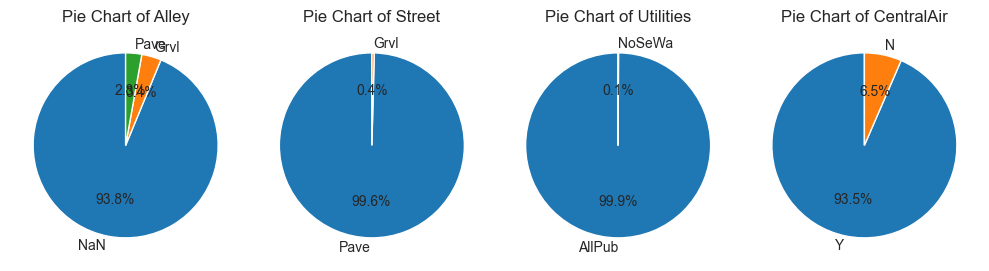

In [99]:
plot_pie_chart(data_df, cols)

- Street and Utilities have skewed distribution

<Axes: xlabel='Street', ylabel='SalePrice'>

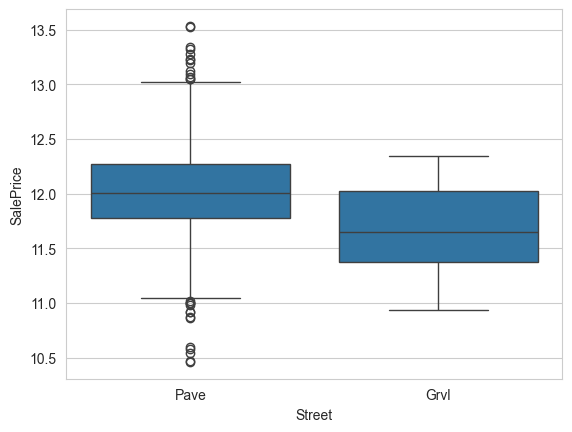

In [100]:
import seaborn as sns
sns.boxplot(data=data_df, x='Street', y='SalePrice')

- all records mostly "AllPub" for Utilities
- PoolQC,Alley,MiscFeature will be dropped due to large number of missing values

In [101]:
train_label = data_df['SalePrice'].reset_index(drop=True)

data_df = data_df.drop('SalePrice', axis=1)

In [103]:
# HANDLE the missing data in other columns
def handle_missing (df):
    
    # drop theses columns due to large null values or many same values
    df = df.drop(['Utilities','PoolQC','MiscFeature','Alley'], axis=1)
    
    # Null value likely means No Fence so fill as "None"
    df["Fence"] = df["Fence"].fillna("None") 
    
    # Null value likely means No Fireplace so fill as "None"
    df["FireplaceQu"] = df["FireplaceQu"].fillna("None")
    
    # Lot frontage is the feet of street connected to property, which is likely similar to the neighbourhood houses, so fill Median value
    df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].median())
    
    # Null value likely means  typical(Typ)
    df["Functional"] = df["Functional"].fillna("Typ")
    
    # Only one null value so fill as the most frequent value(mode)
    df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])  
    
    # Only one null value so fill as the most frequent value(mode)
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    
    # Very few null value so fill with the most frequent value(mode)
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    
    # Null value likely means no masonry veneer
    df["MasVnrType"] = df["MasVnrType"].fillna("None") #so fill as "None" (since categorical feature)
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)      #so fill as o
    
    # Only one null value so fill as the most frequent value(mode)
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    
    #MSZoning is general zoning classification,Very few null value so fill with the most frequent value(mode)
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
    
    #Null value likely means no Identified type of dwelling so fill as "None"
    df['MSSubClass'] = df['MSSubClass'].fillna("None")
    
    # Null value likely means No Garage, so fill as "None" (since these are categorical features)
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        df[col] = df[col].fillna('None')
    
    # Null value likely means No Garage and no cars in garage, so fill as 0
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        df[col] = df[col].fillna(0)
    
    # Null value likely means No Basement, so fill as 0
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df[col] = df[col].fillna(0)
    
    # Null value likely means No Basement, so fill as "None" (since these are categorical features)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        df[col] = df[col].fillna('None')
    
    return df

In [104]:
data_df = handle_missing(data_df)
test_df = handle_missing(test_df)

In [105]:
def add_new_cols(df):
    
    df['Total_SF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] 
                             + (0.5 * df['BsmtHalfBath']))

    df['Total_Porch_SF'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + 
                            df['ScreenPorch'] + df['WoodDeckSF'])

    df['Total_Square_Feet'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF'])
    
    df['Total_Quality'] = df['OverallQual'] + df['OverallCond']
    
    return df

In [106]:
data_df = add_new_cols(data_df)
test_df = add_new_cols(test_df)

## Check data types

In [107]:
gr = data_df.columns.to_series().groupby(data_df.dtypes).groups
{k.name: v for k, v in gr.items()}

{'int64': Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
        '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
        'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
        'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
        'MiscVal', 'MoSold', 'YrSold', 'Total_SF', 'Total_Porch_SF',
        'Total_Square_Feet', 'Total_Quality'],
       dtype='object'),
 'float64': Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'Total_Bathrooms'], dtype='object'),
 'object': Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrType', 'ExterQual', 'ExterCon

In [109]:
print(data_df.shape)

(1460, 80)
